# Imports

In [1]:
import numpy as np

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

from collections import Counter

import os

import json

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.utils as ku 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import string

import re

import pickle

# Constants

In [2]:
BASE_DATA_PATH = os.path.join('..', 'app', 'model')

MODEL_LOSS = 'categorical_crossentropy'
MODEL_OPTIMIZER = 'adam'
MODEL_DENSE_ACTIVATION = 'softmax'
MODEL_EMBEDDING_SIZE = 8
MODEL_LSTM_OUTPUT_DIM = 32
MODEL_DROPOUT_RATE = 0.2
MODEL_NAME = 'text_gen_model.h5'

VOCAB_FILE_NAME = 'anecedotes_vocab.json'

EPOCHS = 300

# Seeds

In [3]:
def seed_everything(seed_value = 0):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    
seed_everything()

# Read dataset

In [14]:
def read_json(directory, filename):
    path = os.path.join(directory, filename)
    return pd.read_json(path)['quizz']

dataframes = [read_json(BASE_DATA_PATH, dataset) for dataset in os.listdir(BASE_DATA_PATH)]

In [16]:
def get_anecdotes(dataframes):
    anecdotes = []
    for i in range(0, len(dataframes)):
        df = dataframes[i]
        for level in ['debutant', 'confirme', 'expert']:
            for j in range(0, len(df[level])):
                anecdotes.append(df[level][j]['anecdote'])
    return anecdotes

anecdotes = get_anecdotes(dataframes)

# Preprocess

In [17]:
def get_most_frequents(anecdotes):
    word_list = [sentence.split(" ") for sentence in anecdotes]
    most_freq_words = Counter([item for sub_item in word_list for item in sub_item]).most_common()[:200]
    return [most_freq_word[0] for most_freq_word in most_freq_words]

def remove_most_freq_words(anecdote, most_freq_words):
    return " ".join([word for word in anecdote.split(" ") if word not in most_freq_words])
    

def preprocess(anecdote):
    anecdote = re.sub("'|«|»", " ", anecdote)
    translator = str.maketrans("", "", string.punctuation)
    anecdote = anecdote.translate(translator)
    anecdote = re.sub(" +", " ", anecdote)
    return anecdote.lower()

anecdotes = [preprocess(anecdote) for anecdote in anecdotes]
most_freq_words = get_most_frequents(anecdotes)
anecdotes = [remove_most_freq_words(anecdote, most_freq_words) for anecdote in anecdotes]

# Generate sequence of N-grams tokens

In [18]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    return total_words

total_words = get_sequence_of_tokens(anecdotes)
print(f"There are {total_words} tokens")

There are 5816 tokens


In [19]:
token_list = [tokenizer.texts_to_sequences([anecdote])[0] for anecdote in anecdotes]

In [20]:
tokenizer = Tokenizer()

def get_n_grams_sequence(corpus):
    
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
     
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words
    
inp_sequences, total_words = get_n_grams_sequence(anecdotes)

# Padding sequences and feature-target dataset

In [21]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
    
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes = total_words)
    return predictors, label, max_sequence_len

predictors, labels, max_sequence_len = generate_padded_sequences(inp_sequences)

In [22]:
print(f"Datas have shape, features : {predictors.shape}, targets: {labels.shape}")

Datas have shape, features : (8158, 17), targets: (8158, 5816)


# Split in train-validation set

In [23]:
x_train, x_val, y_train, y_val = train_test_split(predictors, labels, test_size = 0.2, shuffle = True)

# Create model

In [24]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    
    model = Sequential()
    
    model.add(Embedding(input_dim = total_words, 
                        output_dim = MODEL_EMBEDDING_SIZE, 
                        input_length = input_len))
    model.add(LSTM(MODEL_LSTM_OUTPUT_DIM))
    model.add(Dropout(MODEL_DROPOUT_RATE))
    model.add(Dense(total_words, activation = MODEL_DENSE_ACTIVATION))

    model.compile(loss = MODEL_LOSS, optimizer = MODEL_OPTIMIZER)
    
    return model

model = create_model(max_sequence_len, total_words)

model.summary()

W0903 10:54:03.690346 26948 deprecation.py:506] From C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0903 10:54:03.831347 26948 deprecation.py:506] From C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 8)             46528     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5816)              191928    
Total params: 243,704
Trainable params: 243,704
Non-trainable params: 0
_________________________________________________________________


# Model callbacks

In [25]:
model_ckpt_cb = ModelCheckpoint(MODEL_NAME, monitor = 'val_loss', mode = 'min', save_best_only = True)
es_cb = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
callbacks = [model_ckpt_cb, es_cb]

# Fit model

In [26]:
hist = model.fit(predictors, 
                 labels,
                 validation_data = (x_val, y_val),
                 epochs = EPOCHS, 
                 verbose = 1, 
                 callbacks = callbacks, 
                 shuffle = True)

Train on 8158 samples, validate on 1632 samples


W0903 10:54:10.961126 26948 deprecation.py:323] From C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300
8158/8158 [==============================] - 25s 3ms/sample - loss: 8.6813 - val_loss: 8.6358
Epoch 2/300
8158/8158 [==============================] - 19s 2ms/sample - loss: 8.6158 - val_loss: 8.5611
Epoch 3/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 8.5135 - val_loss: 8.4651
Epoch 4/300
8158/8158 [==============================] - 13s 2ms/sample - loss: 8.4041 - val_loss: 8.3003
Epoch 5/300
8158/8158 [==============================] - 11s 1ms/sample - loss: 8.3072 - val_loss: 8.2003
Epoch 6/300
8158/8158 [==============================] - 12s 1ms/sample - loss: 8.2074 - val_loss: 8.0503
Epoch 7/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 8.0810 - val_loss: 7.8981
Epoch 8/300
8158/8158 [==============================] - 13s 2ms/sample - loss: 7.9181 - val_loss: 7.6868
Epoch 9/300
8158/8158 [==============================] - 12s 2ms/sample - loss: 7.7613 - val_loss: 7.5183
Epoch 10/300
8158/8158 [======================

8158/8158 [==============================] - 12s 1ms/sample - loss: 3.0211 - val_loss: 2.5033
Epoch 78/300
8158/8158 [==============================] - 12s 1ms/sample - loss: 3.0015 - val_loss: 2.4740
Epoch 79/300
8158/8158 [==============================] - 12s 2ms/sample - loss: 2.9620 - val_loss: 2.4163
Epoch 80/300
8158/8158 [==============================] - 12s 2ms/sample - loss: 2.9270 - val_loss: 2.4001
Epoch 81/300
8158/8158 [==============================] - 12s 2ms/sample - loss: 2.8863 - val_loss: 2.3409
Epoch 82/300
8158/8158 [==============================] - 13s 2ms/sample - loss: 2.8518 - val_loss: 2.3058
Epoch 83/300
8158/8158 [==============================] - 12s 2ms/sample - loss: 2.8207 - val_loss: 2.2649
Epoch 84/300
8158/8158 [==============================] - 13s 2ms/sample - loss: 2.7684 - val_loss: 2.2313
Epoch 85/300
8158/8158 [==============================] - 13s 2ms/sample - loss: 2.7394 - val_loss: 2.2027
Epoch 86/300
8158/8158 [==========================

8158/8158 [==============================] - 15s 2ms/sample - loss: 1.4054 - val_loss: 0.8164
Epoch 154/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 1.4166 - val_loss: 0.8022
Epoch 155/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 1.3874 - val_loss: 0.8031
Epoch 156/300
8158/8158 [==============================] - 16s 2ms/sample - loss: 1.3867 - val_loss: 0.7974
Epoch 157/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 1.3931 - val_loss: 0.7874
Epoch 158/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 1.3753 - val_loss: 0.7700
Epoch 159/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 1.3581 - val_loss: 0.7709
Epoch 160/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 1.3311 - val_loss: 0.7680
Epoch 161/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 1.3395 - val_loss: 0.7505
Epoch 162/300
8158/8158 [=================

Epoch 229/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 0.8865 - val_loss: 0.3703
Epoch 230/300
8158/8158 [==============================] - 15s 2ms/sample - loss: 0.8874 - val_loss: 0.3705
Epoch 231/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 0.8761 - val_loss: 0.3687
Epoch 232/300
8158/8158 [==============================] - 15s 2ms/sample - loss: 0.8614 - val_loss: 0.3901
Epoch 233/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 0.8836 - val_loss: 0.3742
Epoch 234/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 0.8689 - val_loss: 0.3635
Epoch 235/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 0.8753 - val_loss: 0.3613
Epoch 236/300
8158/8158 [==============================] - 15s 2ms/sample - loss: 0.8812 - val_loss: 0.3580
Epoch 237/300
8158/8158 [==============================] - 14s 2ms/sample - loss: 0.8596 - val_loss: 0.3589
Epoch 238/300
8158/8158 [===

# Plot training history

<IPython.core.display.Javascript object>


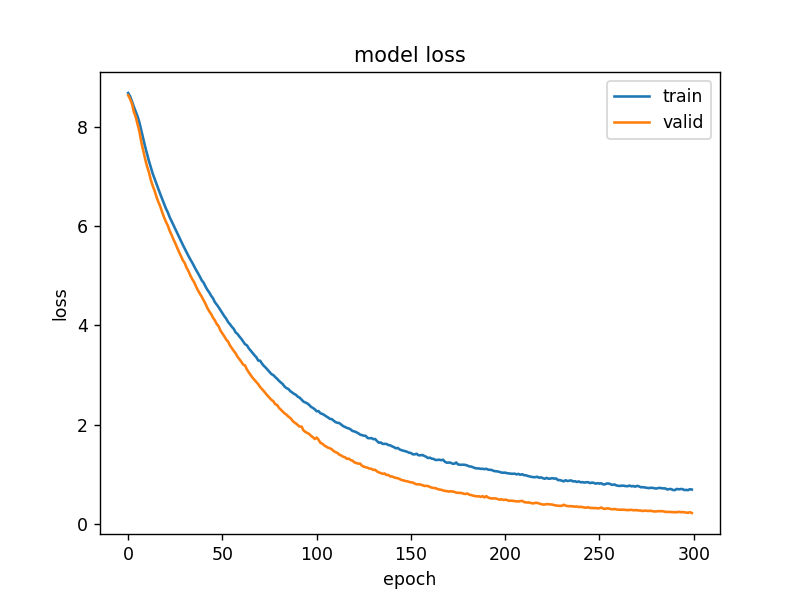

In [27]:
%matplotlib notebook 

def plot_training_hist(hist): 
    plt.plot(hist.history['loss'])  
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid'])
    
plot_training_hist(hist)

# Generate text

In [28]:
def generate_text(seed_text, model, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen = max_sequence_len - 1, padding = 'pre')
    predicted = model.predict(token_list, verbose = 0)
    predicted = predicted.flatten()
    predicted = np.random.choice(len(predicted), 3, p = predicted)
    output_words = []
    for word, index in tokenizer.word_index.items():
        if index in predicted:
            output_words.append(word)
    return output_words

generate_text("Le c est un language", model, 18)

['accueillir', 'ludique', 'poser']

# Save vocabulary as json

In [29]:
def save_vocab_as_json(filename, words):
    with open(filename, 'w') as json_file:
          json.dump(words, json_file)
            
save_vocab_as_json(VOCAB_FILE_NAME, tokenizer.word_docs)

# Save both tokenizers

In [30]:
with open('first_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
    
with open('second_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)